# Programmable OER Example Simulations

    This notebook contains an example for each type of programmable OER simulation in our manuscript: https://doi.org/10.26434/chemrxiv-2024-gs6zn
    The code was developed in Julia 1.8.4 and has not been tested on other versions.

    Run the following cell once every time you start the kernel:

In [1]:
using CSV, DataFrames, DifferentialEquations, NBInclude, PyPlot, Trapz
setprecision(100)
include("Base_OER_Functs.jl");

## Static Simulations

### Simple static simulation

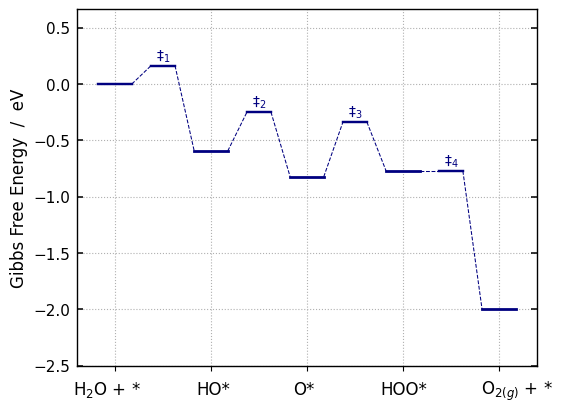

In [2]:
# Specify parameters for simulation
ΔGvolc = 1.5 # eV
η = 0.5      # V
Ea_eq = 0.46 # eV


# Calculates & plots reaction coordinate
U = 1.23 + η
ΔGrxn, U_eq = calc_thermo(ΔGvolc,U);
rc = plot_reaction_coord(ΔGrxn,U,Ea_eq);

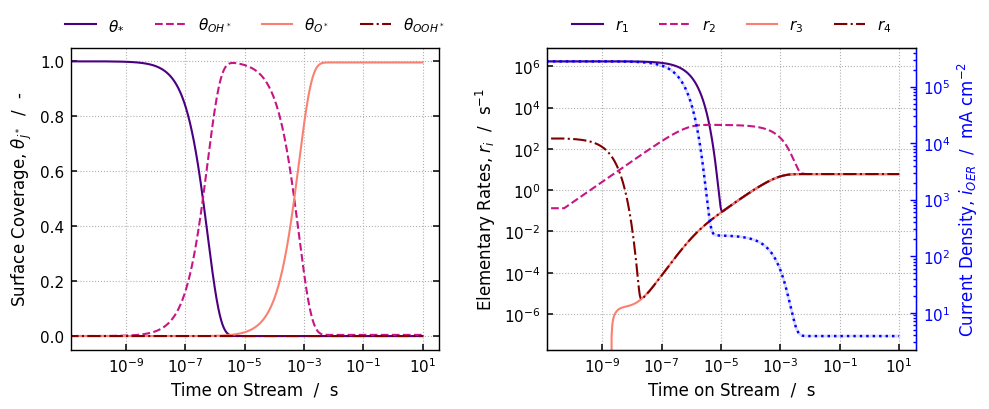

In [3]:
# Runs simulation

# Calculate rate constants
k, K = calc_ks_matAgEaeq(U_eq,U,ΔGrxn,Ea_eq);

# Set tolerances, solver parameters
tols = [1e-17, 1e-18]
u0 = [1., 0., 0., 0.]
tspan = [0,10]

# Run static OER simulation
t, u, r, i_OER = run_staticOER(u0,tspan,tols,k)

# Plot results
plot_static(t,u,r,i_OER);

### Static simulation with degree of rate control

    Note that the DRC packages below will throw errors when loaded, but the code should still run (at least on v1.8.4). If you are unable to get this to work, use the finite difference approach instead (currently commented out)

In [ ]:
# Run this cell once to load packages for autodiff DRC analysis.
using DiffEqSensitivity, ForwardDiff

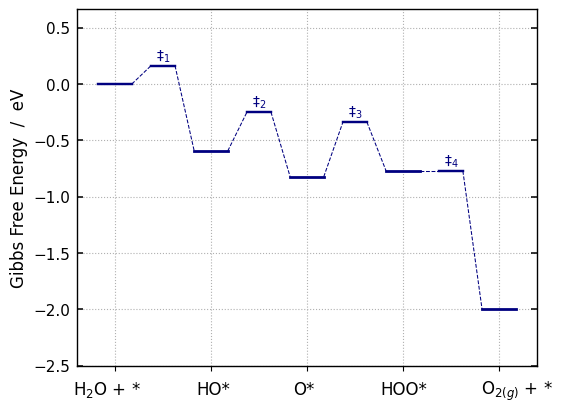

In [5]:
# Specify parameters for simulation
ΔGvolc = 1.5 # eV
η = 0.5      # V
Ea_eq = 0.46 # eV


# Calculates & plots reaction coordinate
U = 1.23 + η
ΔGrxn, U_eq = calc_thermo(ΔGvolc,U);
rc = plot_reaction_coord(ΔGrxn,U,Ea_eq);

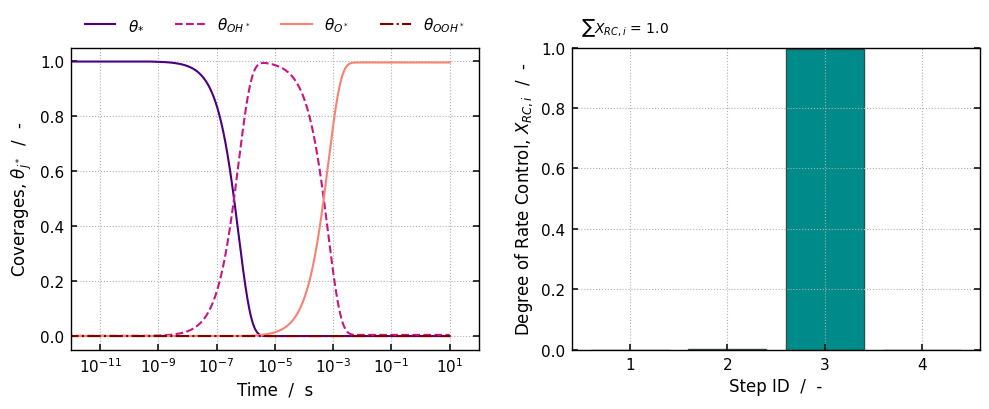

In [6]:
# Runs simulation

# Calculate rate constants
k, K = calc_ks_matAgEaeq(U_eq,U,ΔGrxn,Ea_eq);

# Set tolerances, solver parameters
tols = [1e-17, 1e-18]
u0 = [1., 0., 0., 0.]
tspan = [0,10]

# Calculates DRCs using auto diff
prob = ODEProblem(state_equation_DRC, big.(u0), big.(tspan), big.(k[1:4]))
ode_sol = solve(prob, RadauIIA5(), reltol=tols[1], abstol=tols[2]);
ad_drc = ForwardDiff.jacobian(rate_wrapper, log.(big.(k[1:4])))
plot_drc = plot_DRC_results(ode_sol,ad_drc);

#=
# Calculates DRCs using finite differene
ε = 1e-3
fd_drc = solve(prob, RadauIIA5(), reltol=tols[1], abstol=tols[2])
plot_fddrc = plot_DRC_results(ode_sol,fd_drc');
=#

## Dynamic Simulation Example

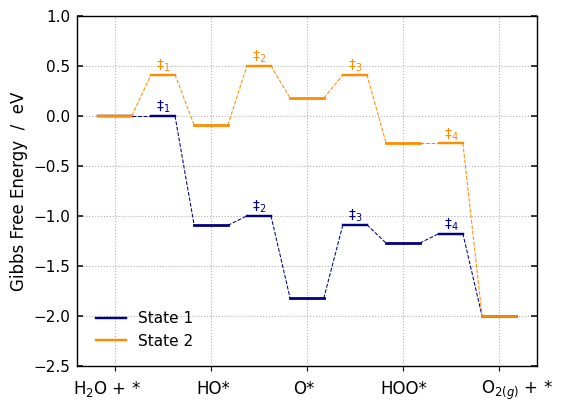

In [7]:
# Specify parameters for simulation
ΔGvolc = 1.5 # eV (center point)
ΔΔG = 1.0    # eV (amplitude)
f = 1e3      # Hz (frequency)
D = 0.25      # -  (duty cycle)

η = 0.5      # V
Ea_eq = 0.46 # eV


# Calculates & plots reaction coordinate
U = 1.23 + η
ΔGrxn1, U_eq1 = calc_thermo((ΔGvolc-ΔΔG/2),U)
ΔGrxn2, U_eq2 = calc_thermo((ΔGvolc+ΔΔG/2),U);
ΔGrxn = hcat(ΔGrxn1,ΔGrxn2)
rc = plot_reaction_coord(ΔGrxn,U,Ea_eq);

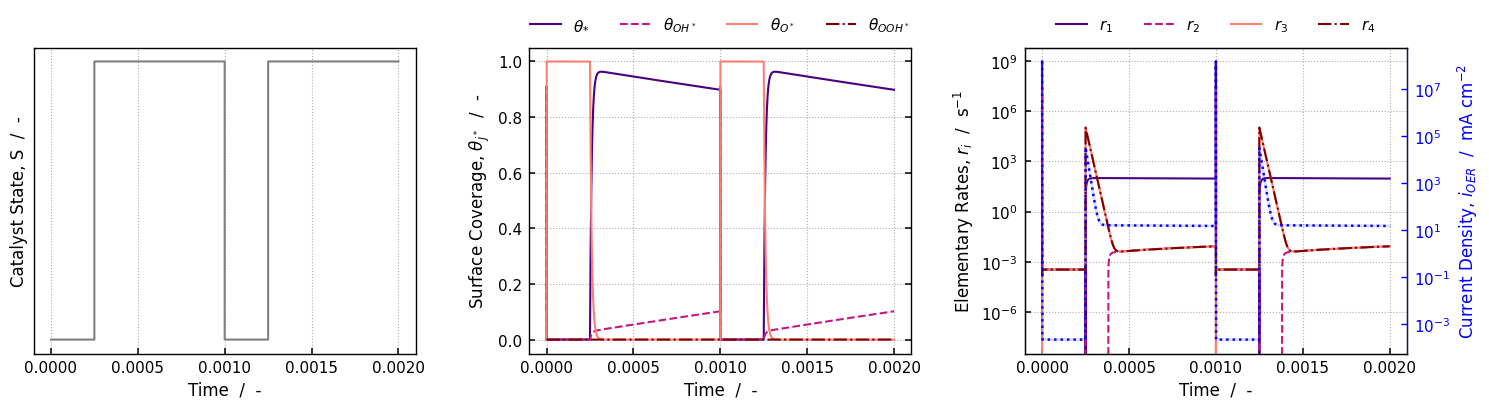

In [8]:
# Runs simulation
# Specify additional inputs
nosc = 500 # max number oscillations
tols = [1e-17, 1e-18, 1e-3]

df_timeAvg, df_SSinst, SSplot = run_dynamicOER_OscCat(Ea_eq,ΔGvolc,ΔΔG,f,D,η,tols,nosc,true);